In [1]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


# データ並列訓練(Distributed Data Parallel)

- 単一プログラムで複数データを訓練する方法(?)として広く知られている

- DDPモデルが各プロセスに複製され, 各モデルに対しては、異なる入力データサンプルが与えられる
- 複製された各モデルを同期させるために**勾配情報を共有**する
- <u>共有した勾配情報を重ね合わせて勾配演算を行うことで,訓練速度の向上することができる</u>

## torch.nn.DataParallel

- `torch.nn.DataParallel`を利用することで, 最小限のコーディングでシングルマシン・マルチGPUによる並列化を実現できる
- `torch.nn.DataParallel`は簡単に実装できるが, ベストなパフォーマンスにはなりえない
    - すべてのフォワードパスでモデルが複製されるため、必然的にそのシングルプロセス・マルチスレッド並列化がGIL(※)の競合に直面するため
    - Global Interpreter Lock(GIL): 複数スレッドでオブジェクトがインスタンス化できないなど、Pythonのマルチスレッド処理の速度弊害になる機能。[参考サイト](https://qiita.com/ttiger55/items/5e1d5a3405d2b3ef8f40)

## torch.nn.DistributedDataParallel

- DistributedDataParallel(DDP)は, DataParallelに比べるとちょっと手間がかかる
- モデルはフォワードパス毎でなく, DDPの構築時にブロードキャストされるので, 訓練速度を向上できる
- DDPはマルチプロセス並列化を使用するため, 複製されたモデル間でも使える
  - マルチプロセスなのでGILの競合が発生しない(?)
  
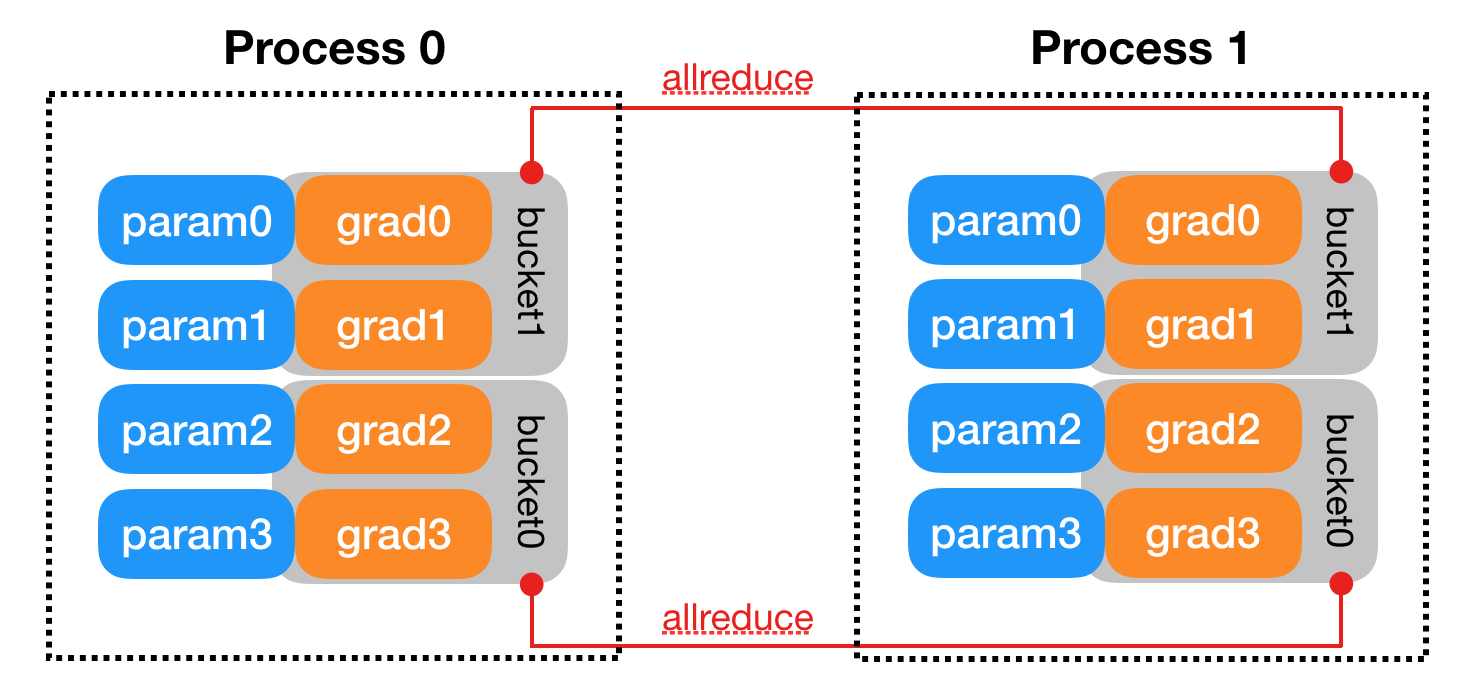

In [2]:
"""python3
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
from torch.nn.parallel import DistributedDataParallel as DDP


def example(rank, world_size):
    # create default process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    # create local model
    model = nn.Linear(10, 10).to(rank)
    # construct DDP model
    ddp_model = DDP(model, device_ids=[rank])
    # define loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    # forward pass
    outputs = ddp_model(torch.randn(20, 10).to(rank))
    labels = torch.randn(20, 10).to(rank)
    # backward pass
    loss_fn(outputs, labels).backward()
    # update parameters
    optimizer.step()

def main():
    world_size = 2
    mp.spawn(example,
        args=(world_size,),
        nprocs=world_size,
        join=True)

if __name__=="__main__":
    # Environment variables which need to be
    # set when using c10d's default "env"
    # initialization mode.
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "29500"
    main()
"""

'python3\nimport torch\nimport torch.distributed as dist\nimport torch.multiprocessing as mp\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.nn.parallel import DistributedDataParallel as DDP\n\n\ndef example(rank, world_size):\n    # create default process group\n    dist.init_process_group("gloo", rank=rank, world_size=world_size)\n    # create local model\n    model = nn.Linear(10, 10).to(rank)\n    # construct DDP model\n    ddp_model = DDP(model, device_ids=[rank])\n    # define loss function and optimizer\n    loss_fn = nn.MSELoss()\n    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)\n\n    # forward pass\n    outputs = ddp_model(torch.randn(20, 10).to(rank))\n    labels = torch.randn(20, 10).to(rank)\n    # backward pass\n    loss_fn(outputs, labels).backward()\n    # update parameters\n    optimizer.step()\n\ndef main():\n    world_size = 2\n    mp.spawn(example,\n        args=(world_size,),\n        nprocs=world_size,\n        join=True)\n\nif __name__=

# torchelastic

- DDPでは各プロセスが密接に同期している必要がある(すべてのプロセスのAllReduce通信が一致する必要がある)
- グループ内のプロセスの一つで、エラーが発生して場合, AllReduce通信が非同期状態となるため, クラッシュやハングアップの原因となる
- 訓練中に障害が発生することが予想される場合や、リソースが動的に縮小・拡大したりする可能性がある場合については、torchelasticを使用する

# RPC型分散訓練(RPC)

- 分散パイプライン並列化, パラメータサーバパラダイム, 
- データ並列型訓練には収まらない, 汎用的な訓練構造をサポートするために開発された
- リモートに存在するオブジェクトの存続を管理し, マシンの境界を越えて自動微分エンジンを拡張する際に役立つ

- `torch.distributed.rpc`は以下の機能を提供する
  - `RPC`: リモートワーカー上に存在する関数の実行をサポートする
  - `RRef`: リモートオブジェクトの存在を管理する際に有用
  - `Distributed Autograd`: マシン間の垣根を越えて, 自動微分を拡張する
  - `Distributed Optimizer`: パラメータを更新する際にDistributed Optimizerエンジンによって, 勾配を計算し, 参加しているワーカーと自動連携する

torchelastic > Distributed DataParallel + 起動スクリプト > Distributed DataParallel > DataParallel > 特別な対応しない


# シングルマシン環境におけるモデル並列訓練

T.B.W

# 6.3 分散データ並列訓練入門

- DDPを使用するアプリケーションでは、複数のプロセスを生成し、プロセスごとに単一のDDPインスタンスを作成する必要がある
    - DDP は `torch.distributed`パッケージの集合通信を使用して、勾配とバッファを同期する
    - DDPでは, `model.parameters()`で得られる各パラメータに対して, 自動微分のフックを登録する。
    - 対応する勾配が計算されたときに, そのフックがコールされ, その処理でプロセス間の勾配が同期される  
    - [ref. DDP](https://pytorch.org/docs/master/notes/ddp.html)
    
- DDPの推奨使用法: 複製したモデルを複数のデバイスに展開できる状態にして, 複製したモデルごとに1つのプロセスを生成する
- DDPのプロセスはマシンを跨いで使用することはできない

## DataParallelとDistributedDataPararell

- DataParallelの方が簡単だが, DDPの方が早い
- **DataParallelはモデル並列と同時に使用することはできない**
    - モデルが大きすぎて, 単一のGPUに収まらない場合, モデル並列を利用する必要がある
    - DDPとモデル並列を組み合わせた場合、各DDPプロセスはモデル並列を使用し、すべてのプロセスが共同してデータ並列を使用することになってしまう

- 複数台のマシンでモデルを扱う場合や, ユースケースとしてデータ並列化では要件を満たせない場合は, [**RPC API**](https://pytorch.org/docs/stable/rpc.html)を使う

## 基本的なユースケース

- DDPモジュールを作成するには, **プロセスグループを適切に設定する必要がある**
- 詳細は次

In [5]:
import os
import sys
import tempfile
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

def setup(rank, world_size):
    if sys.platform == 'win32':
        # win環境はとりあえずエラーで無視する
        raise RuntimeError

    else:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'

        # Initialize process group
        dist.init_process_group('gloo', rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

- 簡易的なモジュールを作り, DDPでラップしてみる
- 異なるDDPプロセスが異なるモデルのパラメータの初期値から開始され得る点は心配しなくていい
- DDPはモデルの状態を, ランク設定値を利用して, 順次実行する(?)
- DDPのコンストラクタ内に存在する他の全てのプロセスにブロードキャストする

In [ ]:
# テキトーなモデル

class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = nn.Linear(10, 10)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(10, 5)

def forward(self, x):
    return self.net2(self.relu(self.net1(x)))

def demo_basic(rank, world_size):
    print(f'Running basic DDP example on rank {rank}')
    setup(rank, world_size)

    # モデルを作成してrank_idとともにGPUに移動
    model = ToyModel().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.01)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()

def run_demo(demo_fn, world_size):
    mp.spawn(demo_fn, args=(world_size,), nprocs=world_size, join=True)

- DDPを使うと, 下位レベルの通信の詳細を意識せずにコーディングできる
- 勾配を同期する通信は`backward()`の最中に発生する
- `backward()`が終わったタイミングでは, `param.grad`は同期された状態になっている

## 歪んだ処理速度

- DDPは, コンストラクタ, 順伝播, 逆伝播が分散処理の同期のポイント

- 異なるプロセスは同じ数の同期処理を起動して, 同じ順序で処理を実行し, ほぼ同時に各同期ポイントに入ることが前提

- ユーザはこれを実現できるように, プロセス間でワークロードの分散を均等にしなければならない
    - これをしないと, 一部のプロセスがタイムアウトして, 処理に失敗してしまう

- 処理速度の歪みやバラつきは, [init_process_group](https://pytorch.org/docs/stable/distributed.html#torch.distributed.init_process_group)を呼ぶ際に, 十分なtimeout値を設定して対処する

## チェックポイントの保存と読み込み

- DDPでも`torch.save`や`torch.load`を使って, チェックポイントを使う点は同じ[モデルの保存と読み込み](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

- DDPを使用する際の, チェックポイント保存のオーバーヘッドを減らすコツとして, 以下のようなテクニックがある
  - 1つのプロセスでのみモデルを保存し, その後に全てのプロセスで保存したモデルを読み込む
  - このテクニックを使う場合, **全プロセスは, モデルの保存が終了する前に, モデルを読み込みしないようにする必要がある**

- モジュールを読み込む際は, あるプロセスが他のデバイスに入り込まないように, `map_location`を適切に設定しなければならない
  - map_locationが抜けている場合, モデルはCPUにロードされてしまい, それを各プロセスが複製するので, 意味なくなってしまう
  
- より発展的な障害回復と柔軟性のあるサポートについては、[TorchElastic](https://pytorch.org/elastic)を参照

In [ ]:
def demo_checkpoint(rank, world_size):
    print(f'Running DDP checkpoint example on rank {rank}')
    setup(rank, world_size)

    model = ToyModel().to(rank)
    ddp_model = DDP(model, device_ids = [rank])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    CHECKPOINT_PATH = tempfile.gettempdir() + '/model.checkpoint'

    if rank == 0:
        # すべてのプロセスは同じランダムパラメータから始まり, backward時に勾配が同期される
        # すべてのプロセスが同じパラメータを扱う必要がある(?)

        # すべてのプロセスでモデルを保存する必要はないので, 最もrankが高いプロセスでだけ保存する
        torch.save(ddp_model.state_dict(), CHECKPOINT_PATH)

    # プロセス0がモデルを保存した後に, 他のプロセスが動作するようにロックをかける(?)
    print(f'pid: {os.getppid()}: --- barriered!')
    dist.barrier()
    print(f'pid: {os.getppid()}: --- relaunched!')

    # 各プロセスごとに適切なmap_locationを設定する
    map_location = {'cuda:%d' % 0: 'cuda:%d' % rank}
    print(f'pid: {os.getppid()}, map: {map_location}')
    ddp_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=map_location))

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn = nn.MSELoss()
    loss_fn(outputs, labels).backward()
    optimizer.step()

    # DDPのBackwardにおいて, AllReduce処理がすでに同期処理として機能しているため
    # 以下の処理では, ファイル削除のガードを目的としたdist.barrier()は必要ない(?)
    if rank == 0:
        os.remove(CHECKPOINT_PATH)

    cleanup()

## DDPとモデル並列化の組み合わせ

- DDPはマルチGPU(モデル並列化)と組み合わせて使用できる
- それは膨大なデータ量で大規模なモデルの訓練に役立つ

- マルチGPUモデルをDDPに与える際は, `device_ids`と`output_devices`を設定してはならない
    - 入力データと出力データは`forward()`メソッドによって適切なデバイスに設定されるため

In [ ]:
class ToyMpModel(nn.Module):
    def __init__(self, dev0, dev1) -> None:
        super().__init__(ToyModel, self).__init__()
        self.dev0 = dev0
        self.dev1 = dev1
        self.net1 = torch.nn.Linear(10, 10).to(dev0)
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5).to(dev1)

    def forward(self, x):
        x = x.to(self.dev0)
        x = self.relu(self.net1(x))
        x = x.to(self.dev1)
        return self.net2(x)


def demo_model_parallel(rank, world_size):
    print(f'Running DDP with model parallel example on rank {rank}')
    setup(rank, world_size)

    # プロセスで使用するmp_modelとデバイスを設定する
    dev0 = rank * 2
    dev1 = rank * 2 + 1
    mp_model = ToyMpModel(dev0, dev1)
    ddp_mp_model = DDP(mp_model)

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_mp_model.parameters(), lr=.001)
    
    optimizer.zero_grad()

    # 出力はdev1に行われる(最終層がdev1に配置されているから)
    outputs = ddp_mp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(dev1)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()

if __name__ == "__main__":
    n_gpus = torch.cuda.device_count()
    if n_gpus < 2:
        print(f"Requires at least 8 GPUs to run, but got {n_gpus}.")
    else:
        run_demo(demo_basic, 8)
        run_demo(demo_checkpoint, 8)
        run_demo(demo_model_parallel, 4)

NameError: name 'nn' is not defined